<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [ ]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

In [ ]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

На данный момент стандартом является **Universal Dependencies**.

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [ ]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [ ]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [ ]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [ ]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

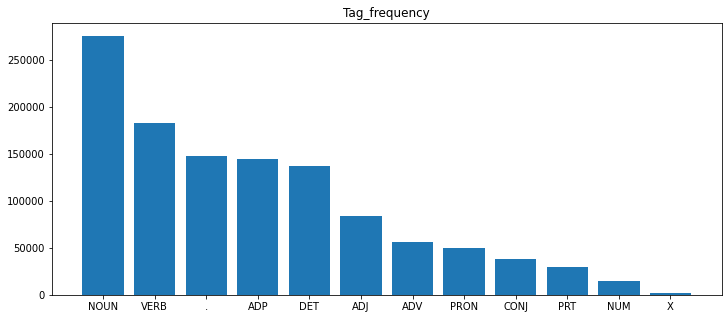

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

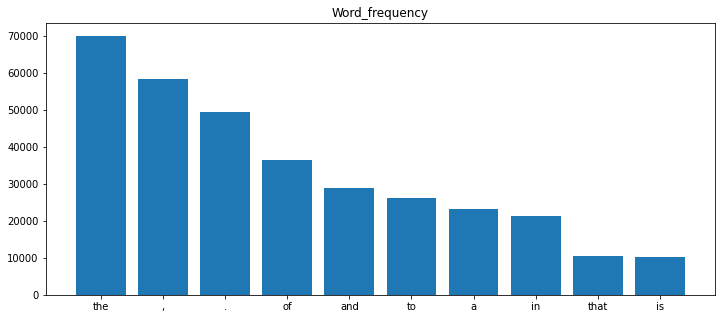

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

ОТВЕТ: 23

In [ ]:
word_num['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

ОТВЕТ: time

In [ ]:
def get_most_pop(words):
    word_tag_num = nltk.FreqDist(words)
    words_with_popular_tag = {x: word_tag_num[x] for x in words if x[1] == tag_num.index[0]}
    words_with_popular_tag = sorted(words_with_popular_tag.items(), key=lambda x: -x[1])
    word_and_tag, count = words_with_popular_tag[0]
    word, tag = word_and_tag
    return word, tag, count

In [ ]:
word, tag, count = get_most_pop(brown_tagged_words)

In [ ]:
print(f'word: {word}')
print(f'tag: {tag}')
print(f'count: {count}')

word: time
tag: NOUN
count: 1597


In [ ]:
most_pop_all_categories = word

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

<ipython-input-50-bbfc7ee8c09a>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_brown_tagged_sents = np.array(my_brown_tagged_sents)


In [ ]:
brown_tagged_words_humor = brown.tagged_words(tagset='universal', categories='humor')
word, tag, count = get_most_pop(brown_tagged_words_humor)
print(f'word: {word}')
print(f'tag: {tag}')
print(f'count: {count}')
most_pop_humor = word

word: time
tag: NOUN
count: 43


In [ ]:
len(train_sents)

947

In [ ]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
class HiddenMarkovModel:    
    def __init__(self, most_pop):
        self.most_pop = most_pop
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                word, tag = sent[i]
                B.loc[word, tag] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[tag, sent[i + 1][1]] += 1 # пара тег-тег
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self.most_pop
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s])
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [ ]:
my_model = HiddenMarkovModel(most_pop_humor)
my_model = my_model.fit(train_sents)

In [ ]:
most_pop_humor in my_model.words

True

In [ ]:
my_model.B.loc[most_pop_humor, 'NOUN']

0.01001001001001001

In [ ]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
preds = my_model.predict(sents)
preds

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?

VERB

In [ ]:
preds[0][1]

'VERB'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

NOUN :)

In [ ]:
preds[3][1]

'NOUN'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). 

In [ ]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for word, tag in sent]
        words = [word for word, tag in sent]
        preds = my_model.predict([words])
        true_pred += (preds[0] == tags).sum()
        num_pred += len(tags)
    score = true_pred / num_pred * 100
    print("Accuracy:", score, '%')
    return score

In [ ]:
score = accuracy_score(my_model, test_sents)

Accuracy: 88.82847256549678 %


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [ ]:
round(score, 1)

88.8

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

20.2

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [ ]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger('NOUN')

In [ ]:
score = default_tagger.accuracy(test_sents)

In [ ]:
round((score * 100), 1)

20.2

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
from nltk.tag.mapping import map_tag

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
words = [word for sent in test_sents for word, tag in sent]
result = nltk.pos_tag(words, tagset='universal')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
tags = np.array([tag for sent in test_sents for word, tag in sent])
preds_nltk = np.array([tag for word, tag in result])
acc_nltk = (tags == preds_nltk).sum() / len(tags)
round(acc_nltk, 2)

0.89

In [ ]:
!pip install rnnmorph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 84.9 MB/s eta 0:00:00
  Created wheel for rnnmorph: filename=rnnmorph-0.4.1-py3-none-any.whl size=19746378 sha256=1e05a9bb5b36850aceda163b503ee2c0fdd0cc22e2aa92f022e13eb2de56890c
  Stored in directory: /root/.cache/pip/wheels/4b/47/48/13dc27987d34abf46ca5fb2877fb993edd01cd95153863f84d
  Created wheel for russian-tagsets: filename=russian_tagsets-0.6-py3-none-any.whl size=24637 sha256=b1ca0a088f67163e1a4c40ca705335d00da9ab8540a80a4628bb611c2f63f2d3
  Stored in directory: /root/

In [ ]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
res = predictor.predict(words)

1/1 [==============================] - 8s 8s/step


In [ ]:
preds_rnn = np.array([x.pos for x in res])

In [ ]:
acc_rnn = (tags == preds_rnn).sum() / len(tags)
round(acc_rnn, 2)

0.63

### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

NLTK - 0.89

RNN - 0.63

In [ ]:
print(set(preds_nltk))
print(set(preds_rnn))

{'PRT', 'DET', 'PRON', 'ADV', 'ADP', 'ADJ', '.', 'VERB', 'NOUN', 'CONJ', 'NUM'}
{'INTJ', 'PUNCT', 'DET', 'PRON', 'X', 'SCONJ', 'ADV', 'PART', 'CCONJ', 'ADP', 'PROPN', 'ADJ', 'VERB', 'NOUN', 'NUM', 'AUX'}


## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


In [ ]:
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [ ]:
from torchtext.legacy.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [ ]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [ ]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 4135
Unique tokens in target (en) vocabulary: 13
['<unk>', 'under', 'buy', 'hold', 'buying', 'lemon', 'slid', 'anecdote', 'boundless', 'committed', 'developed', 'excluded', 'gott', 'instances', 'make-ready', 'none', "policeman's", 'replenished', 'silesia', 'tasti-freeze', 'venture']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'PRON', 'ADJ', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [ ]:
print(vars(train_data.examples[9]))

{'words': ['i.e.', ',', 'burglars', 'who', 'rob', 'while', 'the', 'tenants', 'are', 'absent', ',', 'in', 'contrast', 'to', 'hot-slough', 'prowlers', ',', 'those', 'who', 'work', 'while', 'the', 'occupants', 'are', 'home', '.'], 'tags': ['ADV', '.', 'NOUN', 'PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'VERB', 'ADJ', '.', 'ADP', 'NOUN', 'ADP', 'ADJ', 'NOUN', '.', 'DET', 'PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

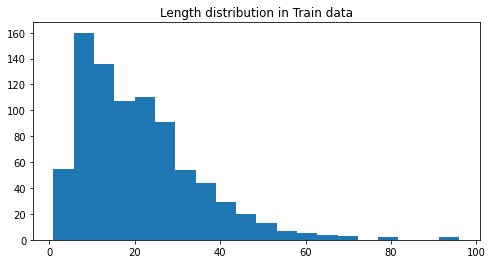

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [ ]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[14, 2, 2]

### Модель и её обучение

In [ ]:
import torch
torch.version.cuda

'11.1'

Инициализируем нашу модель

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.bidirectional = bidirectional
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=2, bidirectional=bidirectional)
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))
        # [sent len, batch size, emb_dim]

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
        # [sent len, batch size, output_dim]
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
EMB_DIM = 100
HID_DIM = 256
OUTPUT_DIM = len(TAG.vocab)
DROPOUT = 0.2
BIDIRECTIONAL = True

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(4135, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): LSTM(100, 256, num_layers=2, bidirectional=True)
  (tag): Linear(in_features=512, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [ ]:
def count_parameters(model):
    return sum(x.shape.numel() for x in model.parameters())

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,730,313 trainable parameters


In [ ]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        words = batch.words   
        tags = batch.tags
        

        optimizer.zero_grad()
        
        output = model(words)
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        tags = tags.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        loss = criterion(output, tags)
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            words = batch.words   
            tags = batch.tags

            output = model(words)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output.view(-1, output_dim)
            tags = tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

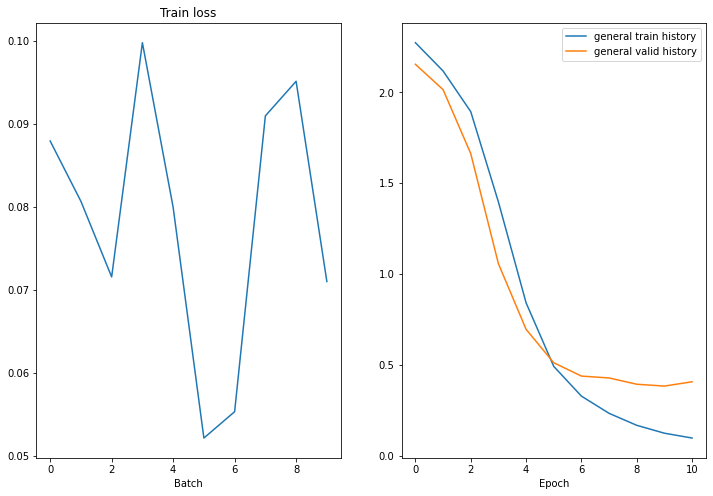

Epoch: 12 | Time: 0m 0s
	Train Loss: 0.077 | Train PPL:   1.080
	 Val. Loss: 0.399 |  Val. PPL:   1.490


In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 3

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [ ]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words = batch.words
            tags = batch.tags

            output = model(words)
            #output = [sent len, batch size, output dim]
            output = output.argmax(-1)

            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [ ]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 89.406 %


In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

Сделаем то же самое для всей выборки

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
from torchtext.legacy.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
INPUT_DIM = len(WORD.vocab)
EMB_DIM = 100
HID_DIM = 256
OUTPUT_DIM = len(TAG.vocab)
DROPOUT = 0.2
BIDIRECTIONAL = True

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(45189, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): LSTM(100, 256, num_layers=2, bidirectional=True)
  (tag): Linear(in_features=512, out_features=13, bias=True)
)

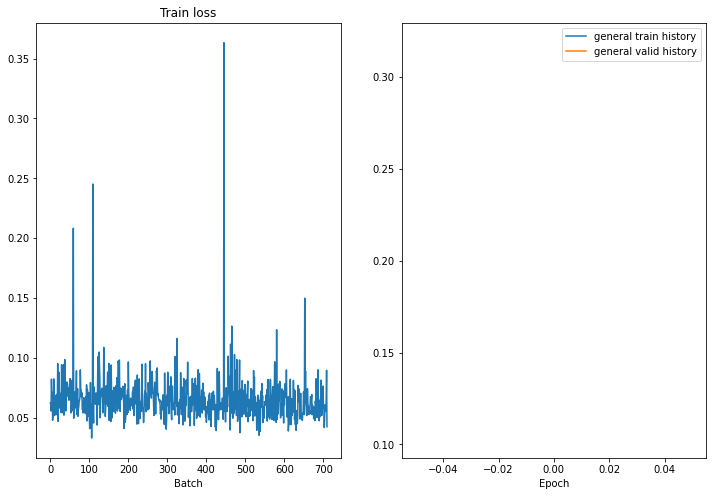

Epoch: 02 | Time: 0m 41s
	Train Loss: 0.065 | Train PPL:   1.068
	 Val. Loss: 0.083 |  Val. PPL:   1.086


In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 2
CLIP = 1
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 97.464 %


Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [ ]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93

Пример решение нашей задачи:

In [ ]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [ ]:
print_tags(model, pos_data[-1])

From           VERB
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          NOUN
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


HiddenMarkov на всем корпусе

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

<ipython-input-103-8afe09009997>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_brown_tagged_sents = np.array(my_brown_tagged_sents)


In [ ]:
my_model = HiddenMarkovModel(most_pop_all_categories)
my_model = my_model.fit(train_sents)

In [ ]:
score = accuracy_score(my_model, test_sents)

Accuracy: 96.26295331104619 %


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе


1) Humor

- HiddenMarkov Accuracy: 88.8 %
- LstmTagger Accuracy (epoch=12, clip=1): 89.3 %

При epoch из отрезка [10, 17] и clip из [1, 2] accuracy было в диапазоне [88, 89] и было лучшим (89.3) при epoch=12, clip=1.

2) Весь корпус

- HiddenMarkov Accuracy: 96.2 %
- LstmTagger Accuracy (epoch=2, clip=1): 97.4 %